In [49]:
# basic data analysis dan visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="Paired")
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

# statistic
from scipy.stats import normaltest,kruskal

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,RobustScaler
import category_encoders as ce

# model regression
#pip install catboost
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import catboost
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

# model selection & hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, KFold

# metric regression
from sklearn.metrics import mean_absolute_error

# Model Interpretation
import shap

import warnings
warnings.filterwarnings('ignore')

import time
shap.initjs()

In [1]:
%store -r df
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,3
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,4
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,4
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,3
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,1
...,...,...,...,...,...,...,...,...,...,...,...
108535,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw,8
108536,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw,12
108537,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw,11
108538,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw,14


# Handing Missing Value

## Tax

In [2]:
df['tax'].isna().sum()

9196

In [3]:
df[df['tax']==0]['tax'].value_counts()

0.0    4926
Name: tax, dtype: int64

Berdasarkan data di atas, didapatkan informasi bahwa terdapat mobil yg memiliki nilai `tax` sebesar 0. Hal ini tidak mungkin terjadi karena berdasarkan regulasi yg berlaku di UK, kendaraan dengan jenis bahan bakar `Diesel` dan `Petrol` pasti dikenakan pajak. Oleh karena itu, data `tax = NaN` dan `tax = 0` akan diasumsikan sebagai _Missing Value_ dan akan dibuatkan kolom baru untuk menandai data tersebut merupakan _Missing Value_ atau bukan.

Referensi:
- https://www.autoexpress.co.uk/best-cars-vans/89081/best-tax-free-cars-2021
- https://www.gov.uk/vehicle-tax-rate-tables

In [5]:
df['tax']=df['tax'].fillna(0)

In [6]:
df['tax_is_missing']=np.where(df['tax']==0,1,0)

In [7]:
df['tax'].isna().sum()

0

## MPG

In [8]:
df['mpg'].isna().sum()

9196

In [9]:
df[df['mpg']==0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age,tax_is_missing


Berdasarkan data di atas, didapatkan informasi bahwa terdapat mobil dengan data `mpg = NaN`. Oleh karena itu akan dibuatkan kolom baru untuk menandai data tersebut merupakan _Missing Value_ atau bukan.

In [11]:
df['mpg']=df['mpg'].fillna(0)

In [12]:
df['mpg_is_missing']=np.where(df['mpg']==0,1,0)

In [13]:
df['mpg'].isna().sum()

0

## engineSize

In [14]:
df['engineSize'].isna().sum()

0

In [15]:
df[df['engineSize']==0]['engineSize'].value_counts()

0.0    245
Name: engineSize, dtype: int64

Berdasarkan data di atas, didapatkan informasi bahwa terdapat mobil yg memiliki nilai `engineSize` sebesar 0. Hal ini tidak mungkin terjadi karena tidak mungkin terdapat kendaraan tanpa memiliki kapasitas mesin. Oleh karena itu, data tersebut akan diasumsikan sebagai _Missing Value_ dan akan dibuatkan kolom baru untuk menandai data tersebut merupakan _Missing Value_ atau bukan.

In [16]:
df['engineSize_is_missing']=np.where(df['engineSize']==0,1,0)

# Splitting Data

In [17]:
x = df.drop(columns=['year', 'price'])
y = df['price']

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    random_state=2020
)

# Preprocessing

In [21]:
transformer = ColumnTransformer([
    ('one hot encoding', OneHotEncoder(drop='first'), ['transmission', 'fuelType', 'brand']),
    ('binary encoding', ce.BinaryEncoder(),['model']),
], remainder='passthrough')

# Data Transform

In [22]:
x_train_preprocessed=pd.DataFrame(transformer.fit_transform(x_train))
x_test_preprocessed=pd.DataFrame(transformer.transform(x_test))

# Model Benchmark

In [23]:
modelLinReg = LinearRegression()
modelRidge = Ridge()
modelLasso = Lasso()
modelTree = DecisionTreeRegressor(random_state=2020, criterion='mae')
modelKNN = KNeighborsRegressor()
modelCB = CatBoostRegressor(random_state=2020, loss_function='MAE', silent=True)

In [24]:
models = [
    modelLinReg, 
#     modelRidge,
#     modelLasso,
#     modelTree,
#     modelKNN,
    modelCB,
]

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

mae_scores = []
mae_std = []
for i in models:
    scores = []
    
    for train_index, val_index in kf.split(x_train):
    #     print("TRAIN:", train_index, "VAL:", val_index)
        x1_train, x_val = x_train.iloc[train_index], x_train.iloc[val_index]
        y1_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        estimator = Pipeline([
            ('preprocess', transformer),
            ('model', i)
        ])
        
        estimator.fit(x1_train, y1_train)
        scores.append(mean_absolute_error(y_val, estimator.predict(x_val)))

    mae_scores.append(np.mean(scores))
    mae_std.append(np.std(scores))

    

In [ ]:
modelBenchmark=pd.DataFrame({
#     'model': ['linreg', 'ridge', 'lasso', 'tree', 'knn', 'cb'],
    'model': ['linreg','cb'],
    'mae_score_mean': mae_scores,
    'mae_score_std': mae_std,
})
modelBenchmark

> Berdasarkan hasil model benchmark diatas didapatkan bahwa model `CatBoost` memiliki nilai rata-rata MAE yang paling rendah yaitu **1446.447665** yang berarti model tersebut memiliki performa paling baik serta nilai standard deviasi yang cukup baik senilai **30.458116**.

> Berdasarkan data tersebut, untuk selanjutnya model `CatBoost` yang akan digunakan dan diproses lebih lanjut.

# Model Improvement 1

Pada tahap ini akan dilakukan tuning terhadap `categorical features`, antara lain `model`, `transmission`, `fuelType`, dan `brand`. Pada tahap `model benchmark` fitur-fitur tersebut _encoding_ dilakukan secara manual, sedangkan pada tahap ini akandilakukan _encoding_ secara otomatis berdasarkan parameter yg disediakan dari model CatBoost.

In [27]:
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age,tax_is_missing,mpg_is_missing,engineSize_is_missing
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,3,0,0,0
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,4,0,0,0
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,4,0,0,0
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,3,0,0,0
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108535,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw,8,0,0,0
108536,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw,12,0,0,0
108537,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw,11,0,0,0
108538,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw,14,0,0,0


In [28]:
df['model']=df['model'].astype('category')
df['transmission']=df['transmission'].astype('category')
df['fuelType']=df['fuelType'].astype('category')
df['brand']=df['brand'].astype('category')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105051 entries, 0 to 108539
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   model                  105051 non-null  category
 1   year                   105051 non-null  int64   
 2   price                  105051 non-null  int64   
 3   transmission           105051 non-null  category
 4   mileage                105051 non-null  int64   
 5   fuelType               105051 non-null  category
 6   tax                    105051 non-null  float64 
 7   mpg                    105051 non-null  float64 
 8   engineSize             105051 non-null  float64 
 9   brand                  105051 non-null  category
 10  age                    105051 non-null  int64   
 11  tax_is_missing         105051 non-null  int32   
 12  mpg_is_missing         105051 non-null  int32   
 13  engineSize_is_missing  105051 non-null  int32   
dtypes: category(4), floa

In [30]:
modelCB2 = CatBoostRegressor(random_state=2020, loss_function='MAE', silent=True, cat_features=['model','transmission','fuelType','brand'])

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

mae_scores = []
mae_std = []
scores = []

for train_index, val_index in kf.split(x_train):
#     print("TRAIN:", train_index, "VAL:", val_index)
    x1_train, x_val = x_train.iloc[train_index], x_train.iloc[val_index]
    y1_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    modelCB2.fit(x1_train, y1_train)
    scores.append(mean_absolute_error(y_val, modelCB2.predict(x_val)))

mae_scores.append(np.mean(scores))
mae_std.append(np.std(scores))

In [35]:
modelImprov_1=pd.DataFrame({
    'model': ['cb_category'],
    'mae_score_mean': mae_scores,
    'mae_score_std': mae_std,
})
modelImprov_1

,model,mae_score_mean,mae_score_std
0,cb_category,1400.721085,27.266465


> Setelah dilakukan tuning terhadap `categorical features`, terdapat peningkatan performa sebesar 3.16% yaitu _MAE Score_ dari **1446.447665** menjadi **1400.721085** serta peningkatan pada stabilitas model sebesar 10.48% yaitu _STDev_ dari **30.458116** menjadi **27.266465**.

# Model Improvement 2

Pada tahap ini akan dilakukan tuning untuk mencari parameter terbaik yg akan digunakan pada model CatBoost.

In [45]:
# !pip install hyperopt
# !pip install colorama

In [67]:
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

N_HYPEROPT_PROBES = 1
HYPEROPT_ALGO = tpe.suggest
colorama.init()

In [61]:
D_train = catboost.Pool(x_train, y_train, cat_features=['model','transmission','fuelType','brand'])
D_test = catboost.Pool(x_test, y_test, cat_features=['model','transmission','fuelType','brand'])

In [81]:
x2_train, x_val, y2_train, y_val = train_test_split(
    x_train,
    y_train,
    random_state=2020
)

In [52]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])

    return params

In [54]:
obj_call_count = 0
cur_best_mae = np.inf
log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [84]:
def objective(space):
    global obj_call_count, cur_best_mae

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_mae={:7.5f}'.format(obj_call_count,cur_best_mae) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = CatBoostRegressor(learning_rate=params['learning_rate'],
                              depth=int(params['depth']),
                              loss_function='MAE',
#                               use_best_model=True,
                              eval_metric='MAE',
                              verbose=False
                             )
    
    model.fit(x2_train, y2_train, verbose=False, cat_features=['model','transmission','fuelType','brand'])
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict(x_val)
    test_mae = mean_absolute_error(y_val, y_pred)

    log_writer.write('mae={:<7.5f} Params:{} nb_trees={}\n'.format(test_mae, params_str, nb_trees))
    log_writer.flush()

    if test_mae<cur_best_mae:
        cur_best_mae = test_mae
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_mae) + colorama.Fore.RESET)


    return{'mae':test_mae, 'status': STATUS_OK }

In [85]:
space = {
        'depth': hp.quniform('depth', 1, 6, 1), # (label, low, high, q)
        'learning_rate': hp.loguniform('learning_rate',  -5.0, -2) # (label, low, high)
       }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print(best)
print('\n\n')

                                                     
CatBoost objective call #11 cur_best_mae=    inf
Params: depth=6.0 learning_rate=0.021426698769568764 
nb_trees=1000                                        
NEW BEST LOSS=1482.4832886906722                     
  0%|          | 0/1 [01:18<?, ?trial/s, best loss=?]

job exception: 



  0%|          | 0/1 [01:18<?, ?trial/s, best loss=?]


InvalidLoss: 

# Hyperparameter Tuning

In [23]:
learning_rate = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1]
max_depth= [5, 7, 9]

kf = KFold(n_splits=5, shuffle=True, random_state=2020)
hyperparam_space = []
mae_scores = []
mae_std = []

score = 9999
bestParam = ''

for i in learning_rate:
    for k in max_depth:
        hyperparam_space.append({
            'learning_rate': i,
            'max_depth': k

        })
        scores = []
        
        modelCB = CatBoostRegressor(learning_rate=i, max_depth=k, loss_function='MAE', random_state=2020, silent=True)
        estimator = Pipeline([
            ('preprocess', transformer),
            ('model', modelCB)
        ])
        
        for train_index, val_index in kf.split(x_train):
        #     print("TRAIN:", train_index, "VAL:", val_index)
            x1_train, x_val = x_train.iloc[train_index], x_train.iloc[val_index]
            y1_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

            estimator.fit(x1_train, y1_train)
            scores.append(mean_absolute_error(y_val, estimator.predict(x_val)))
        
        mae_scores.append(np.mean(scores))
        mae_std.append(np.std(scores))
        if np.mean(scores) < score:
            score = np.mean(scores)
            bestParam = estimator[1].get_all_params()
        


In [27]:
pd.set_option('display.max_colwidth', None)
hscb_df = pd.DataFrame({
    'parameter': hyperparam_space,
    'mae_score_mean': mae_scores,
    'mae_score_std': mae_std,
})
hscb_df.sort_values('mae_score_mean').head(10)

,parameter,mae_score_mean,mae_score_std
0,"{'learning_rate': 0.3, 'max_depth': 9}",1327.069898,20.261916


# Feature Importance

In [29]:
bestModelCB = CatBoostRegressor(learning_rate=bestParam['learning_rate'], loss_function=bestParam['loss_function'], max_depth=bestParam['depth'], random_state=2020, silent=True)
bestEstimator = Pipeline([
            ('preprocess', transformer),
            ('model', bestModelCB)
        ])

bestEstimator.fit(x_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['transmission', 'fuelType',
                                                   'brand'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x12c287850>)])

In [31]:
bestEstimator[1].feature_importances_

array([5.40274642e+00, 1.05939895e-03, 1.00142346e+00, 3.12895835e+00,
       1.36201783e+00, 1.31686759e-01, 3.17537762e-01, 1.47533041e+00,
       7.73672576e-01, 4.91438460e+00, 6.61439332e-01, 1.07919819e+00,
       2.73177615e+00, 1.44326887e+00, 8.35161714e+00, 3.46398612e+00,
       1.64854643e+01, 2.98524394e+01, 1.72439015e+01, 1.74399765e-01,
       0.00000000e+00, 3.69176746e-03])

In [32]:
features = list(transformer.transformers_[0][1].get_feature_names()) \
    + ['mileage', 'tax', 'mpg', 'engineSize', 'age', 'tax_is_missing', 'mpg_is_missing', 'engineSize_is_missing']
features

['x0_Manual',
 'x0_Other',
 'x0_Semi-Auto',
 'x1_Petrol',
 'x2_bmw',
 'x2_cclass',
 'x2_focus',
 'x2_ford',
 'x2_hyundi',
 'x2_merc',
 'x2_skoda',
 'x2_toyota',
 'x2_vauxhall',
 'x2_vw',
 'mileage',
 'tax',
 'mpg',
 'engineSize',
 'age',
 'tax_is_missing',
 'mpg_is_missing',
 'engineSize_is_missing']

In [35]:
featureImportance = pd.DataFrame({ 'importance':bestEstimator[1].feature_importances_},index=features)
featureImportance.sort_values(by='importance', ascending=False)

,importance
engineSize,29.852439
age,17.243901
mpg,16.485464
mileage,8.351617
x0_Manual,5.402746
x2_merc,4.914385
tax,3.463986
x1_Petrol,3.128958
x2_vauxhall,2.731776
x2_ford,1.475330


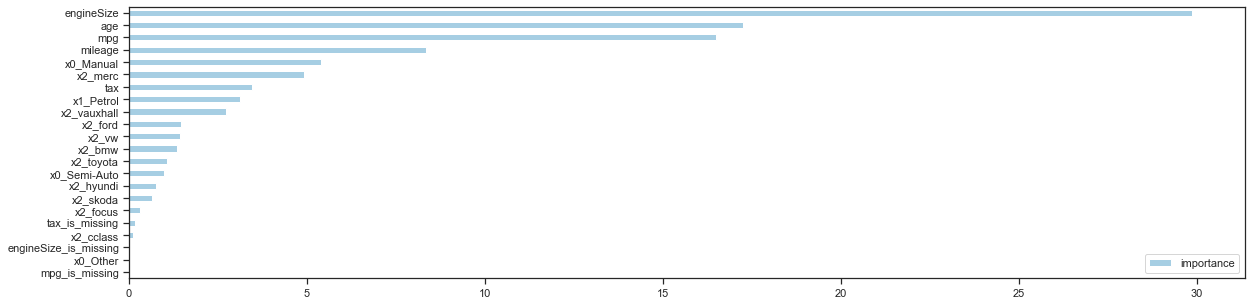

In [36]:
featureImportance.sort_values(by='importance').plot(kind='barh',figsize=(20,5))
plt.legend(loc=4)
plt.show()

> Berdasarkan data diatas, terdapat 1 feature yang tidak signifikan karena memiliki nilai feature importance 0 yaitu `mpg_is_missing`.

# Model-based Testing


## Before Tuning

In [37]:
CB_before = CatBoostRegressor(learning_rate=1, max_depth=5, loss_function='MAE', random_state=2020, silent=True)
estimatorBefore = Pipeline([
            ('preprocess', transformer),
            ('model', CB_before)
        ])
estimatorBefore.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['transmission', 'fuelType',
                                                   'brand'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x12c829b50>)])

In [39]:
y_pred_before = estimatorBefore.predict(x_test)
mae_before = mean_absolute_error(y_test, y_pred_before)
mae_before

1441.034014929518

## After Tuning

In [40]:
y_pred_best = bestEstimator.predict(x_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
mae_best

1315.2517988472594

> setelah dilakukan hyperparameter tuning terjadi peningkatan performa sebesar 8.72% yaitu MAE score dari **1441.034** menjadi **1315.251**

## Result

In [41]:
pred_res = pd.DataFrame({
    'actual': y_test,
    'prediction': y_pred_best
})

In [42]:
pred_res['selisih'] = pred_res['prediction'] - pred_res['actual']
pred_res['in_range'] = np.where(abs(pred_res['selisih']) < mae_best, True, False)
pred_res['status'] = np.where(pred_res['prediction'] < pred_res['actual'], 'Overprice', 'Underprice')


In [43]:
pred_res.head()

,actual,prediction,selisih,in_range,status
90194,10230,10834.580276,604.580276,True,Underprice
11495,6998,8313.174848,1315.174848,True,Underprice
8064,14999,14291.866660,-707.133340,True,Overprice
52763,12891,13720.588225,829.588225,True,Underprice
31952,9290,9982.110848,692.110848,True,Underprice


In [44]:
pred_res['in_range'].value_counts() / pred_res.shape[0] * 100

True     67.75692
False    32.24308
Name: in_range, dtype: float64

# Model Interpretation using SHAP

In [56]:
explainer = shap.Explainer(bestEstimator[1])
shap_values = explainer(x_test_preprocessed)

## Summary for the whole dataset (overall feature importance)

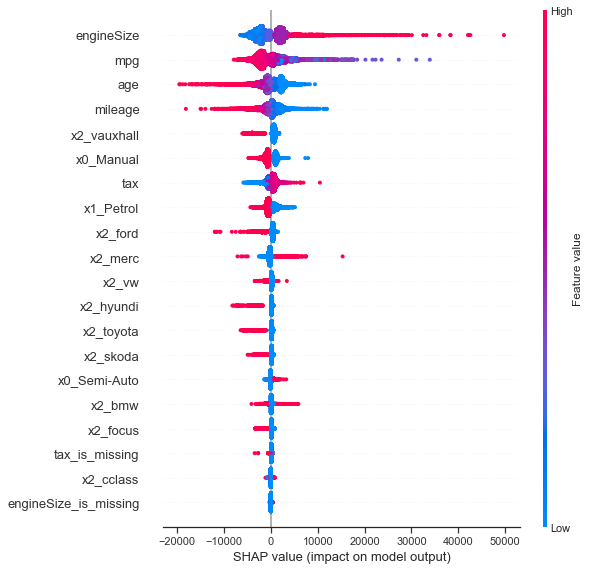

In [60]:
shap.summary_plot(shap_values, features=x_test_preprocessed, feature_names=features)

Dari graph diatas dapat kita simpulkan beberapa point   
* Feature engineSize, mpg, age, mileage dan x2_vauxhall merupakan 5 fitur yang memilik pengaruh tertinggi terhadap price
* Semakin besar nilai engineSize memiliki pengaruh positif yang tinggi terhadap nilai price. Dengan kata lain semakin besar kapasitas mesin suatu mobil maka semakin mahal harga jual mobil tersebut
* Semakin besar nilai mpg, memiliki pengaruh positif yang moderate terhadap nilai price. Dengan kata lain semakin irit mobil maka semakin mahal harga jual mobil tersebut
* Semakin kecil nilai age memiliki pengaruh positif yang tinggi terhadap nilai price. Dengan kata lain semakin muda umur mobil maka semakin mahal harga jual mobil tersebut
* Semakin kecil nilai mileage memiliki pengaruh positif yang tinggi terhadap nilai price. Dengan kata lain semakin rendah jumlah jarak yang telah ditempuh mobil maka semakin mahal harga jual mobil tersebut
* Mobil yang bukan brand vauxhall memiliki pengaruh positif yang tinggi terhadap nilai price. Dengan kata lain, mobil-mobil selain brand vauxhall memiliki pengaruh yang lebih besar dalam penentuan harga jual.

## object-level contributions of features

In [61]:
shap.plots.force(shap_values[1], feature_names=features)

In [62]:
shap.plots.force(shap_values[1441], feature_names=features)

Dari graph diatas kita mengambil 2 observasi data yaitu observasi 1 dan observasi 1441. Perbandingan observasi kedua data tersebut sebagai berikut:

* Pada observasi 1 didapatkan nilai prediksi price sebesar 8,313.17 dimana pada observasi ini fitur-fitur yang **menekan** nilai price menjadi lebih rendah secara berurutan adalah age, mileage, engineSize, transmission, fuelType, dst. Hal ini sejalan dengan analisa yang sudah dilakukan sebelumnya, yaitu:    
    1. Semakin tua umur mobil maka harga mobil akan semakin murah
    2. Semakin jauh total jarak yang sudah ditempuh oleh mobil maka harga mobil akan semakin murah
    3. Semakin kecil kapasitas mesin mobil maka harga mobil akan semakin murah
    
* Pada observasi 1441 didapatkan nilai prediksi price sebesar 27,883.10 dimana pada observasi ini fitur-fitur yang **mendorong** nilai price menjadi lebih tinggi secara berurutan adalah mpg, mileage, age, engineSize, brand, dst. Hal ini sejalan dengan analisa yang sudah dilakukan sebelumnya, yaitu:    
    1. Semakin muda umur mobil maka harga mobil akan semakin mahal
    2. Semakin kecil total jarak yang sudah ditempuh oleh mobil maka harga mobil akan semakin mahal
    3. Semakin besar kapasitas mesin mobil maka harga mobil akan semakin mahal
    